## Clasificador con Pytorch CNN

Se realizó un una red neuronal convolucional de 6 capas dos convolucionales y 2 dos capas lineales cons las respectivas capa de entrada y salida. 

### Librerías

In [2]:
import torch  # 	El paquete PyTorch de nivel superior y la biblioteca tensorial.
import torch.nn as nn   #	Un subpaquete que contiene módulos y clases extensibles para construir redes neuronales.
import torch.optim as optim # Un subpaquete que contiene operaciones de optimización estándar como SGD y Adam.
import torch.nn.functional as F # Una interfaz funcional que contiene operaciones típicas utilizadas para construir redes neuronales como funciones de pérdida y convoluciones.
import torchvision # Un paquete que proporciona acceso a conjuntos de datos populares, arquitecturas de modelos y transformaciones de imágenes para la visión por computadora.
import torchvision.transforms as transforms # Una interfaz que contiene transformaciones comunes para el procesamiento de imágenes.
import torchvision.datasets as dset

# Otras importaciones

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.metrics import confusion_matrix, accuracy_score
#from plotcm import plot_confusion_matrix

import pdb
torch.set_printoptions(linewidth=120)

### Lectura de datos Train

Las imágenes se encuentran en carpetas separadsd por personajes con torchvision.datasets leemos cada carpeta y se asigna una categoría a cada personaje. Dado que las imágenes tienen distinto tamaño se escalaron a 60x60 pixeles, además se estandarizaron y convertidas en tensor.

In [16]:
transform = transforms.Compose(
    [transforms.Resize((60,60)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = dset.ImageFolder(root="../input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset",transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,shuffle=True,num_workers=2)

dataiter = iter(trainloader)
images, labels = dataiter.next()

In [17]:
print(images.shape)
len(Counter(trainset.targets))

torch.Size([16, 3, 60, 60])


42

### Gráfica de un lote de 16 imágenes. 

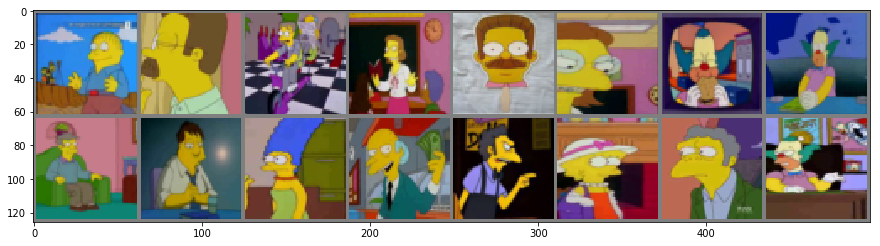

In [18]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images))

### Construcción CNN

Dado que las imágenes son a color en la primera convolución entran 3 canales, utilizaremos un Kernel de 5 y padding de 2.

In [19]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        
        self.fc1 = nn.Linear(in_features=32 * 15 * 15, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=90)
        self.out = nn.Linear(in_features=90, out_features=42)
        
    def forward(self, t):
        # (1) input layer
        t = t
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2,stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2,stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 32 * 15 * 15)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)

        return t

In [20]:
#Funcion predicciones 
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

### Entrenando a la Red

Utilizamos lotes de 500 imágenes, una tasa de aprendizaje de 0.001 y una función de perdida cross_entropy.

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network = Network()
network.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.001)
train_loader = torch.utils.data.DataLoader(
    trainset
    ,batch_size=500
    ,shuffle=True
)

for epoch in range(12):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print("epoch", epoch, "total_correct:", total_correct, "loss:", total_loss)

epoch 0 total_correct: 4042 loss: 124.04156374931335
epoch 1 total_correct: 8656 loss: 91.77041411399841
epoch 2 total_correct: 10698 loss: 76.2109044790268
epoch 3 total_correct: 11840 loss: 66.65604555606842
epoch 4 total_correct: 12920 loss: 58.28968417644501
epoch 5 total_correct: 14114 loss: 49.83319365978241
epoch 6 total_correct: 14905 loss: 43.80363941192627
epoch 7 total_correct: 15733 loss: 37.73452174663544
epoch 8 total_correct: 16397 loss: 32.54988914728165
epoch 9 total_correct: 17073 loss: 27.945561468601227
epoch 10 total_correct: 17736 loss: 23.12246984243393
epoch 11 total_correct: 18219 loss: 19.421203166246414


### Métricas

In [22]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    all_preds = all_preds.to(device)
    for batch in loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [23]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(trainset, batch_size=1000)
    train_preds = get_all_preds(network, prediction_loader)

In [24]:
cm = confusion_matrix(trainset.targets,train_preds.argmax(dim=1).cpu())
print(cm)
accuracy_score(trainset.targets,train_preds.argmax(dim=1).cpu())

[[804   0   3 ...   0   0   0]
 [  0  20   0 ...   0   0   0]
 [  0   0 610 ...   0   0   0]
 ...
 [  0   0   1 ...  34   0   0]
 [  2   0   0 ...   0   4   0]
 [  1   0   2 ...   0   0 139]]


0.8948550136148665